# M02. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Dates:
    - Created: 4/19/2024
    - Updated: 4/21/2024

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [3]:
%run "A02. MLB API.ipynb"
%run "A03. Steamer.ipynb"

In [4]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dataset

In [5]:
complete_dataset = create_pa_inputs(park_factors, team_map, 2015, 2023, short=50, long=300)

##### Inputs

In [6]:
# Standardize
complete_dataset[batter_inputs] = batter_stats_scaler.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = pitcher_stats_scaler.transform(complete_dataset[pitcher_inputs])

### Steamer

In [7]:
# Read in Steamer hitters 
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

In [8]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

In [9]:
# Standardize
steamer_hitters_df2[batter_stats_fg] = batter_stats_fg_scaler.transform(steamer_hitters_df2[batter_stats_fg])
steamer_pitchers_df2[pitcher_stats_fg] = pitcher_stats_fg_scaler.transform(steamer_pitchers_df2[pitcher_stats_fg])

### Merge

In [10]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
batter_steamer_dates = list(steamer_hitters_df2['date'].unique())
pitcher_steamer_dates = list(steamer_pitchers_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
complete_dataset["batter_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, batter_steamer_dates))
complete_dataset["pitcher_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, pitcher_steamer_dates))

In [11]:
# Steamer stats we want to keep
batter_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + batter_stats_fg 
pitcher_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + pitcher_stats_fg 

# Merge
complete_merged_df = pd.merge(complete_dataset, steamer_hitters_df2[batter_stats_fg_plus], left_on=['batter', 'batter_date'], right_on=['mlbamid', 'date'], how='inner')
complete_merged_df = pd.merge(complete_merged_df, steamer_pitchers_df2[pitcher_stats_fg_plus], left_on=['pitcher', 'pitcher_date'], right_on=['mlbamid', 'date'], how='inner')

### Impute

##### Option 1: Steamer

In [12]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = batter_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = pitcher_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

##### Option 2: 0s

In [13]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Train Models

##### Dataset

In [14]:
# Filter out events that didn't end with reaching base or an out
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"').reset_index(drop=True)
# Drop early observations (these will generally treat veterans as rookies and could bias results
complete_merged_df = complete_merged_df.drop(index=complete_merged_df.index[:20000])
complete_merged_df.reset_index(inplace=True, drop=True)
# Create year variable
complete_merged_df['year'] = complete_merged_df['date'].astype('str').str[:4]
# Create is_out binary variable
out_list = ['so', 'fo', 'go', 'lo', 'po']
complete_merged_df['is_out'] = complete_merged_df['eventsModel'].str.contains('|'.join(out_list)).astype(int)

In [15]:
# Keep relevant variables
### TESTING
# keep_list = pa_inputs + ['out_b', 'out_b_long', 'out_p', 'out_p_long', 'pa_b', 'pa_p', 'year', 'is_out', 'eventsModel', 'batterName', 'pitcherName']
keep_list = pa_inputs + ['pa_b', 'pa_p', 'year', 'is_out', 'eventsModel', 'batterName', 'pitcherName']
model_dataset = complete_merged_df[keep_list]

In [16]:
outs_dataset = model_dataset[model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset = model_dataset[~model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

### Train/Test Split

##### Option 1: Early/Late Season

In [17]:
# X_train = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.head(int(len(x)*2/3)))
# X_test = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.tail(int(len(x)*1/3)))

##### Option 2: Random

In [18]:
np.random.seed(42)

# Create a column 'split' with random values to achieve a 2/3 to 1/3 split
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

# Drop if missing information
model_dataset.dropna(subset=pa_inputs, inplace=True)
model_dataset.columns = model_dataset.columns.astype(str)

# Split the DataFrame into training and testing sets based on the 'split' column
X_train = model_dataset[model_dataset['split'] == 0].drop('split', axis=1)
X_test = model_dataset[model_dataset['split'] == 1].drop('split', axis=1)

In [19]:
outs_dataset_train = X_train[X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset_train = X_train[~X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [20]:
outs_dataset_test = X_test[X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset_test = X_test[~X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [21]:
# del complete_merged_df, complete_dataset, model_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2  

In [22]:
complete_merged_df.head(1)

,atBatIndex,inning,halfInning,outs,type,id,event,eventType,description,rbi,awayScore,homeScore,batter,batterName,batSide,pitcher,pitcherName,pitchHand,postOnFirst,postOnSecond,postOnThird,start,end,movementReason,gamePk,weather,wind,venue,date_x,away_name,home_name,game_date,game_type_x,venue_id,pitch_number,pitch_name,game_type_y,hc_x,hc_y,hit_location,totalDistance,launchSpeed,launch_angle,launch_speed_angle,woba_value,woba_denom,estimated_ba_using_speedangle,estimated_woba_using_speedangle,iso_value,babip_value,maxSpeed,maxSpin,outs_pre,temperature,windSpeed,windDirection,x_vect,y_vect,eventsModel,year,Cut,b1,b2,b3,bb,fo,go,hbp,hr,lo,po,so,venue_1,venue_10,venue_12,venue_13,venue_14,venue_15,venue_16,venue_17,venue_19,venue_2,venue_22,venue_2392,venue_2394,venue_2395,venue_24,venue_2500,venue_2503,venue_2504,venue_2507,venue_2508,venue_2511,venue_2513,venue_2514,venue_2516,venue_2518,venue_2520,venue_2523,venue_2526,venue_2529,venue_2530,venue_2532,venue_2534,venue_2535,venue_2536,venue_2542,venue_2602,venue_2603,venue_2680,venue_2681,venue_2700,venue_2701,venue_2722,venue_2723,venue_2724,venue_2735,venue_2756,venue_2766,venue_2769,venue_2781,venue_2852,venue_2856,venue_2858,venue_2861,venue_2862,venue_2889,venue_3,venue_31,venue_32,venue_3289,venue_3309,venue_3312,venue_3313,venue_3809,venue_3834,venue_4,venue_4169,venue_4249,venue_4309,venue_4510,venue_4629,venue_4669,venue_4670,venue_4705,venue_4960,venue_5,venue_5000,venue_5010,venue_5315,venue_5325,venue_5340,venue_5365,venue_5380,venue_5381,venue_5445,venue_680,venue_7,p_L,p_R,b_L,b_R,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,startingPitcher,starter,preOnFirst,preOnSecond,preOnThird,onFirst,onSecond,onThird,top,preAwayScore,preHomeScore,score_diff,batterScore,pitcherScore,pa,ab,hard_hit,barrel,spray_angle,to_left,to_middle,to_right,Park Factor,1B,2B,3B,HR,BB,SO,b1_b,b2_b,b3_b,hr_b,bb_b,hbp_b,so_b,fo_b,go_b,lo_b,po_b,estimated_woba_using_speedangle_b,to_left_b,to_middle_b,to_right_b,hard_hit_b,barrel_b,totalDistance_b,maxSpeed_b,maxSpin_b,launchSpeed_b,ab_b,pa_b,b1_p,b2_p,b3_p,hr_p,bb_p,hbp_p,so_p,fo_p,go_p,lo_p,po_p,estimated_woba_using_speedangle_p,to_left_p,to_middle_p,to_right_p,hard_hit_p,barrel_p,totalDistance_p,maxSpeed_p,maxSpin_p,launchSpeed_p,ab_p,pa_p,imp_b,imp_p,woba_b,woba_p,slg_b,slg_p,obp_b,obp_p,iso_b,iso_p,b1_b_long,b2_b_long,b3_b_long,hr_b_long,bb_b_long,hbp_b_long,so_b_long,fo_b_long,go_b_long,lo_b_long,po_b_long,estimated_woba_using_speedangle_b_long,to_left_b_long,to_middle_b_long,to_right_b_long,hard_hit_b_long,barrel_b_long,iso_b_long,slg_b_long,obp_b_long,woba_b_long,totalDistance_b_long,maxSpeed_b_long,maxSpin_b_long,launchSpeed_b_long,ab_b_long,pa_b_long,b1_p_long,b2_p_long,b3_p_long,hr_p_long,bb_p_long,hbp_p_long,so_p_long,fo_p_long,go_p_long,lo_p_long,po_p_long,estimated_woba_using_speedangle_p_long,to_left_p_long,to_middle_p_long,to_right_p_long,hard_hit_p_long,barrel_p_long,iso_p_long,slg_p_long,obp_p_long,woba_p_long,totalDistance_p_long,maxSpeed_p_long,maxSpin_p_long,launchSpeed_p_long,ab_p_long,pa_p_long,batter_date,pitcher_date,mlbamid_x,steamerid_x,date_y,b1_rate,b2_rate,b3_rate,hr_rate,bb_rate,hbp_rate,so_rate,woba,slg,obp,mlbamid_y,steamerid_y,date,H9,HR9,K9,BB9,GBrate,FBrate,LDrate,SIERA,is_out
0,35,5,top,2,atBat,520471,Lineout,field_out,Freddy Galvis lines out to left fielder Jayson Werth.,0,2,2,520471,Freddy Galvis,L,450729,Doug Fister,R,0,0,0,0,0,0,413787,Cloudy.,"5 mph, Out To LF.",Nationals Park.,20150416,Philadelphia Phillies,Washington Nationals,2015-04-16,R,3309,3.000000,Sinker,R,84.380000,91.050000,7.000000,291.000000,87.200000,20.000000,4.000000,0.000000,1.000000,0.373000,0.384000,0.000000,0.000000,87.300000,1974.000000,1,70,5,Out To LF,-3.535534,3.535534,lo,2015,False,0.000000,0.000000,0.000000,0.000000,False,False,False,0.000000,True,False,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [23]:
# #### TEST
# pa_inputs = pa_inputs + ['out_b', 'out_b_long', 'out_p', 'out_p_long']

### Outs vs. Safe

In [2]:
model_dataset.head()

NameError: name 'model_dataset' is not defined

In [24]:
%%time
# This is good! layers = (250,250,250,250,250) x 10 (just takes a while to run) It's good by year too
layers = (250,250,250,250,250)

binary_filename = f"model_binary_voting_{todaysdate}.sav"
print(binary_filename)

iters = 100

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=131, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=1010, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=1022, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    ]


# Create the ensemble classifier using VotingClassifier
model_binary = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-1).fit(X_train[pa_inputs], X_train[['is_out']].values.ravel())

# Save model
pickle.dump(model_binary, open(os.path.join(model_path, binary_filename), 'wb'))

model_binary_voting_20240323.sav
CPU times: total: 719 ms
Wall time: 23min 26s


In [25]:
# Make predictions
proba = model_binary.predict_proba(X_test[pa_inputs])
X_test['is_safe_pred'] = proba[:, 0]  # Assign the first column of probabilities
X_test['is_out_pred']  = proba[:, 1]  # Assign the second column of probabilities

In [26]:
### Add xtiles (to examine how well predictions match actual results)
# model_dataset['decile'] = pd.qcut(model_dataset['is_out_pred'], 10, labels=False)

# df_name = "is_out" + "_df"
# globals()[df_name] = model_dataset.groupby('decile').mean().reset_index()

X_test['decile'] = pd.qcut(X_test['is_out_pred'], 10, labels=False)

globals()["is_out_df"] = X_test.groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()
globals()["is_out_df"] = X_test.query('year_2022 == True or year_2023 == True').groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()
# globals()["is_out_df"] = X_test.query('venue_3 == True').groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()

# Post Processing:
# Create dataframe to adjust predictions to better fit test data
out_df = X_test.groupby('decile').agg({'is_out_pred': ['max', 'mean'], 'is_out': 'mean'})
out_df.columns = ['is_out_pred_max', 'is_out_pred_mean', 'is_out_mean']

out_df.to_pickle(os.path.join(model_path, 'out_df.pkl'))

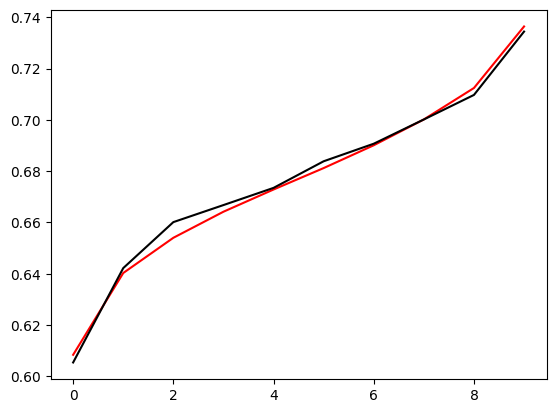

In [27]:
# Create figures
plt.plot(is_out_df['decile'], is_out_df['is_out_pred'], color='red')
plt.plot(is_out_df['decile'], is_out_df['is_out'], color='black')
plt.show() 

In [28]:
dafdafdaf

NameError: name 'dafdafdaf' is not defined

### Outs

In [ ]:
%%time
# Neural network layers
layers = (250,250,250,250,250)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 100

outs_filename = f"model_outs_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(outs_filename)

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.00001, early_stopping=True, validation_fraction=0.1, random_state=3, max_iter=iters),

    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=1, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=2, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=3, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),

]

# Create the ensemble classifier using VotingClassifier
model_outs = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(outs_dataset_train[pa_inputs], outs_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_outs, open(os.path.join(model_path, outs_filename), 'wb'))

In [ ]:
# Predict out types
outs_outputs = list(model_outs.classes_)
outs_outputs_pred = [x + "_pred" for x in outs_outputs]

proba = model_outs.predict_proba(outs_dataset_test[pa_inputs])
for i, col in enumerate(outs_outputs_pred):
    outs_dataset_test[f'{col}'] = proba[:, i]

In [ ]:
# Create deciles
for var in outs_outputs:
    outs_dataset_test[f'{var}_act'] = (outs_dataset_test['eventsModel'] == var).astype('int')
    outs_dataset_test[f'{var}_decile'] = pd.qcut(outs_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    # globals()[df_name] = outs_dataset_test.groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()    
    globals()[df_name] = outs_dataset_test.query('year_2022 == True or year_2023 == True').groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()

In [ ]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(outs_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(0,0.35)


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

### Safe

In [ ]:
%%time
# Neural network layers
layers = (250,250,250,250,250,250,250,250)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 1000
# Alpha
alpha = 0.0005
# Random state
random_state = 1

safe_filename = f"model_safe_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(safe_filename)

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+2, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+3, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+4, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+5, max_iter=iters),

    
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=8, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=9, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=10, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=11, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=12, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(safe_dataset_train[pa_inputs], safe_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_safe, open(os.path.join(model_path, safe_filename), 'wb'))

In [ ]:
# model_safe = pickle.load(open(os.path.join(model_path, "model_safe_relu_250250250250250250250250_1000_20240313.sav"), 'rb'))

In [ ]:
# Predict safe types
safe_outputs = list(model_safe.classes_)
safe_outputs_pred = [x + "_pred" for x in safe_outputs]

proba = model_safe.predict_proba(safe_dataset_test[pa_inputs])
for i, col in enumerate(safe_outputs_pred):
    safe_dataset_test[f'{col}'] = proba[:, i]

In [ ]:
# Create deciles
for var in safe_outputs:
    safe_dataset_test[f'{var}_act'] = (safe_dataset_test['eventsModel'] == var).astype('int')
    safe_dataset_test[f'{var}_decile'] = pd.qcut(safe_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    # globals()[df_name] = safe_dataset_test.groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[df_name] = safe_dataset_test.query('year_2022 == True or year_2023 == True').groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()


In [ ]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(safe_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(globals()[df_name][f'{var}_act'].min(),globals()[df_name][f'{var}_act'].max())
    

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

In [ ]:
hr_df['hr_mse'] = (hr_df['hr_act'] - hr_df['hr_pred']) ** 2
hr_df['hr_mse'].mean()

In [ ]:
var = 'hr'
safe_dataset_test.groupby(f'{var}_decile')[[f'{var}_pred', f'{var}_act']].mean()

In [ ]:
adfa

In [ ]:
safe_dataset_test.groupby('decile')[['hr_pred', 'hr_act']].mean()

In [ ]:
safe_dataset_test.query('year == "2022" | year == "2023"')[['b1_pred', 'b1_act', 'b2_pred', 'b2_act', 'b3_pred', 'b3_act', 'hr_pred', 'hr_act', 'bb_pred', 'bb_act', 'hbp_pred', 'hbp_act']].mean()

In [ ]:
outs_dataset_test.query('year == "2022" | year == "2023"')[['fo_pred', 'fo_act', 'go_pred', 'go_act', 'lo_pred', 'lo_act', 'po_pred', 'po_act', 'so_pred', 'so_act']].mean()